# Visualizing One Tree in the Forest with df_imputed_min

In [16]:
import pandas as pd
import numpy as np
import pandas_profiling
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings("ignore")
import seaborn as sns
import sklearn.metrics as metrics

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score

from sklearn.ensemble import RandomForestClassifier
from pprint import pprint

In [2]:
#import the data
directory = 'C:/githubrepo/7331_Project/data/'
df = pd.read_csv(directory + 'Diabetic_Cleaned.csv')
df_imputed = df
df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 51 columns):
encounter_id                101766 non-null int64
patient_nbr                 101766 non-null int64
race                        101766 non-null object
gender                      101766 non-null object
age                         101766 non-null object
admission_type_id           101766 non-null int64
discharge_disposition_id    101766 non-null int64
admission_source_id         101766 non-null int64
time_in_hospital            101766 non-null int64
medical_specialty           101766 non-null object
num_lab_procedures          101766 non-null int64
num_procedures              101766 non-null int64
num_medications             101766 non-null int64
number_outpatient           101766 non-null int64
number_emergency            101766 non-null int64
number_inpatient            101766 non-null int64
number_diagnoses            101766 non-null int64
max_glu_serum               101766 

In [3]:
#10 age groups; Ordinal encoding
#feature density plot of age can help with answering the question like: does people older age tend to be readmitted?
#can use map/apply function to achieve this

df_imputed.age[df_imputed.age== '[0-10)'] = 1
df_imputed.age[df_imputed.age== '[10-20)'] = 2
df_imputed.age[df_imputed.age== '[20-30)'] = 3
df_imputed.age[df_imputed.age== '[30-40)'] = 4
df_imputed.age[df_imputed.age== '[40-50)'] = 5
df_imputed.age[df_imputed.age== '[50-60)'] = 6
df_imputed.age[df_imputed.age== '[60-70)'] = 7
df_imputed.age[df_imputed.age== '[70-80)'] = 8
df_imputed.age[df_imputed.age== '[80-90)'] = 9
df_imputed.age[df_imputed.age== '[90-100)'] = 10

df_imputed["age"] = df_imputed["age"].astype(int)

In [4]:
dummiesList=["discharge_disposition","admission_source", "admission_type"]
    
df_imputed_min_wDummies = pd.get_dummies(df_imputed[dummiesList])

In [5]:
NumFeatures= ["age","num_medications", "number_diagnoses", "time_in_hospital",
       "number_emergency", "num_lab_procedures", "number_inpatient", "medication_count", "readmitted_tf"]

df_imputed_min_wDummies= pd.concat((df_imputed_min_wDummies, df_imputed[NumFeatures]), axis=1)

In [6]:
df_imputed_min_wDummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 55 columns):
discharge_disposition_Admitted as an inpatient to this hospital                                                                    101766 non-null uint8
discharge_disposition_Discharged to home                                                                                           101766 non-null uint8
discharge_disposition_Discharged/transferred to ICF                                                                                101766 non-null uint8
discharge_disposition_Discharged/transferred to SNF                                                                                101766 non-null uint8
discharge_disposition_Discharged/transferred to a federal health care facility.                                                    101766 non-null uint8
discharge_disposition_Discharged/transferred to a long term care hospital.                                                  

In [7]:
df_imputed=df_imputed_min_wDummies

from sklearn.model_selection import ShuffleSplit

# we want to predict the X and y data as follows:
if 'readmitted_tf' in df_imputed:
    y = df_imputed['readmitted_tf'].values # get the labels we want
    del df_imputed['readmitted_tf'] # get rid of the class label
    X = df_imputed.values # use everything else to predict!

    ## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    #    have converted them into simple matrices to use with scikit learn
    
    
# to use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None)


In [8]:
## Training and Testing Split
# okay, so run through the cross validation loop and set the training and testing variable for one single iteration
for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
      # we want to normalize the features based upon the mean and standard deviation of each column. 
# However, we do not want to accidentally use the testing data to find out the mean and std (this would be snooping)
# to Make things easier, let's start by just using whatever was last stored in the variables:
##    X_train , y_train , X_test, y_test (they were set in a for loop above)
from sklearn.preprocessing import StandardScaler
scl_obj = StandardScaler()

scl_obj.fit(X_train)
X_test_scaled = scl_obj.transform(X_test)

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) 
    

C:\ProgramData\Anaconda3\envs\DS7331_35r\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\envs\DS7331_35r\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\envs\DS7331_35r\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\envs\DS7331_35r\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [9]:
rf_clf = RandomForestClassifier(  random_state = 2000, criterion = 'gini', min_samples_split=10,min_samples_leaf=1,
                                max_features='sqrt', max_depth=50, bootstrap = False,
                                n_estimators = 1800, verbose = False, n_jobs = 4)
rf_clf.fit(X_train_scaled,y_train)

preds = rf_clf.predict(X_test_scaled)
print('Random Forest - roc_auc_score: ', roc_auc_score(y_test, preds)) 

#model without 'medication_count' variable:  Random Forest - roc_auc_score:  0.6601250264605687
#model with 'medication_count' variable:  Random Forest - roc_auc_score:  0.6641114682074046
#slight increase
# ！！！！！！！！！！！！！！model with all variables still got higher auc for RF 0.679376684881603 ！！！！！！！！！！！！！！

Random Forest - roc_auc_score:  0.6644985945227716


In [14]:
#https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
#probs is the result of a model.predict_proba(x_test) call

#This function plots an ROC curve
def rocCurvePlot(probs, y_test1):
    # calculate the fpr and tpr for all thresholds of the classification
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test1, preds)
    roc_auc = metrics.auc(fpr, tpr)

    # method I: plt
    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
# A function to find the optimal cutoff point from ROC curve

#https://stackoverflow.com/questions/28719067/roc-curve-and-cut-off-point-python
def Find_Optimal_Cutoff(target, predicted):
    """Parameters:
    target : Matrix with dependent or target data, where rows are observations
    predicted : Matrix with predicted data, where rows are observations
    ----------
    Return: list type, with optimal cutoff value
    """
    predicted = predicted[:,1]
    fpr, tpr, threshold = metrics.roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.ix[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 

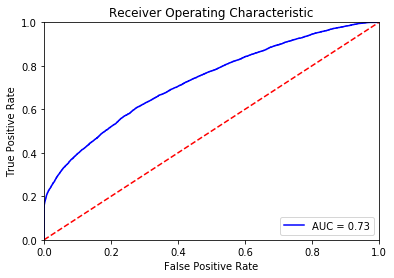

Wall time: 3.17 s


In [17]:
%%time
rocCurvePlot(rf_clf.predict_proba(X_test_scaled), y_test)


In [11]:
#in order to create viz of one tree
final_model_forviz=rf_clf

In [12]:
# Use sklearn to export the tree 
from sklearn.tree import export_graphviz

# Write the decision tree as a dot file
visual_tree =final_model_forviz.estimators_[12]
export_graphviz(visual_tree, out_file = 'C:/Users/Zack/Desktop/best_tree.dot', feature_names = df_imputed.columns.values, 
                precision = 2, filled = True, rounded = True, max_depth = None)

In [13]:
# Use pydot for converting to an image file
#pip3 install pydot
import pydot

# Import the dot file to a graph and then convert to a png
(graph, ) = pydot.graph_from_dot_file('C:/Users/Zack/Desktop/best_tree.dot')
graph.write_jpg('C:/Users/Zack/Desktop/best_tree.jpg')

In [58]:
# XGBoost df_imputed_min dataset model vs. baseline model with all variables model

### XGBoost baseline  model for df_imputed_min dataset

import xgboost as xgb


#XGBOOST parameters 1
MAX_ROUNDS = 1000
EARLY_STOP = 50
OPT_ROUNDS = 1000
VERBOSE_EVAL = 50
RANDOM_STATE = 2000

#XGBOOST transform data into DMatrix format for modeling
dtrain = xgb.DMatrix(X_train_scaled, y_train)
dvalid = xgb.DMatrix(X_test_scaled, y_test)
type(dtrain)


# XGBoost Parameters 2
params = {}
params['objective'] = 'binary:logistic'
#params['objective'] = 'multi:softmax'
#params['objective'] = 'reg:linear'
params['eta'] = 0.039
params['silent'] = True
params['max_depth'] = 2
params['subsample'] = 0.8
params['colsample_bytree'] = 0.9
params['eval_metric'] = 'auc'
params['random_state'] = RANDOM_STATE

watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

In [59]:

xgb_clf = xgb.train(params,
                   dtrain,
                   MAX_ROUNDS,
                   watchlist,
                   early_stopping_rounds = EARLY_STOP,
                   maximize = True,
                   verbose_eval = VERBOSE_EVAL)


#all variables model
#Wall time: 3min 48s
#[999]	train-auc:0.756217	valid-auc:0.748447

#df_imputed_min dataset model (12 varibales) without 'medication_count'
#train within one min, similar auc
#[999]	train-auc:0.74347	valid-auc:0.743672


#df_imputed_min dataset model with 'medication_count'
# train for one min
#[999]	train-auc:0.744676	valid-auc:0.744422

[0]	train-auc:0.630167	valid-auc:0.626652
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[50]	train-auc:0.712641	valid-auc:0.711675
[100]	train-auc:0.719279	valid-auc:0.71933
[150]	train-auc:0.725965	valid-auc:0.727298
[200]	train-auc:0.729865	valid-auc:0.731484
[250]	train-auc:0.732551	valid-auc:0.734486
[300]	train-auc:0.734347	valid-auc:0.736519
[350]	train-auc:0.735593	valid-auc:0.737706
[400]	train-auc:0.736622	valid-auc:0.738797
[450]	train-auc:0.737973	valid-auc:0.739935
[500]	train-auc:0.738855	valid-auc:0.7408
[550]	train-auc:0.739727	valid-auc:0.741469
[600]	train-auc:0.740305	valid-auc:0.742042
[650]	train-auc:0.740912	valid-auc:0.742415
[700]	train-auc:0.741497	valid-auc:0.742847
[750]	train-auc:0.742118	valid-auc:0.743257
[800]	train-auc:0.742659	valid-auc:0.743525
[850]	train-auc:0.743049	valid-auc:0.743724
[900]	train-auc:0.743634	valid-auc:0.743976
[950]	train-auc:0.744101	va

In [21]:
# RandomizedSearchCV
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [22]:
# A parameter grid for XGBoost
#at least include the parameters already included in the baseline model for chance to find one better than base model.
params = {
        'min_child_weight': [1, 5],
        'gamma': [0.5, 1, 2],
        'subsample': [0.6, 0.8],
        'colsample_bytree': [0.6, 0.9],
        'max_depth': [2, 5]
        }

In [23]:
from xgboost import XGBClassifier

xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)

In [24]:
#Thanks for Zack's suggestion
# under the condition of same list of parameters to be tuned:
# all variables model runtime 24-30 mins
# df_imputed_min dataset model 4 mins
## grid search in a parallized fashion

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from datetime import datetime

folds = 3
param_comb = 3

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X_train_scaled,y_train), verbose=50, random_state=2000)

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X_train_scaled, y_train)
timer(start_time) # timing ends here for "start_time" variable

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done   3 out of   9 | elapsed:  1.7min remaining:  3.4min
[Parallel(n_jobs=4)]: Done   4 out of   9 | elapsed:  1.8min remaining:  2.2min
[Parallel(n_jobs=4)]: Done   5 out of   9 | elapsed:  2.0min remaining:  1.6min
[Parallel(n_jobs=4)]: Done   6 out of   9 | elapsed:  2.6min remaining:  1.3min
[Parallel(n_jobs=4)]: Done   7 out of   9 | elapsed:  2.6min remaining:   45.3s
[Parallel(n_jobs=4)]: Done   9 out of   9 | elapsed:  2.8min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   9 out of   9 | elapsed:  2.8min finished

 Time taken: 0 hours 4 minutes and 18.03 seconds.


In [25]:
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)


 Best estimator:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=2, learning_rate=0.02, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=600,
       n_jobs=1, nthread=1, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.6)

 Best normalized gini score for 3-fold search with 3 parameter combinations:
0.4868555900780789

 Best hyperparameters:
{'subsample': 0.6, 'min_child_weight': 1, 'max_depth': 5, 'gamma': 2, 'colsample_bytree': 0.6}


### Results - Best hyperparameters

Best estimator:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=2, learning_rate=0.02, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=600,
       n_jobs=1, nthread=1, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.6)

 Best normalized gini score for 3-fold search with 3 parameter combinations:
0.4868555900780789

 Best hyperparameters:
{'subsample': 0.6, 'min_child_weight': 1, 'max_depth': 5, 'gamma': 2, 'colsample_bytree': 0.6}

In [29]:
#traing time comparsion
#df_imputed_min dataset model vs. baseline model with all variables model
#run for 
#evaulate the performance of the model best parameters
# timer the training time
start_time = timer(None)

xgb_best = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=2, learning_rate=0.02, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=600,
       n_jobs=1, nthread=1, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.6)

xgb_best.fit(X_train_scaled, y_train)

timer(start_time)

#training time
#all variables model Time taken: 0 hours 8 minutes and 24.05 seconds.
#df_imputed_min dataset model Time taken: 0 hours 1 minutes and 22.29 seconds.


 Time taken: 0 hours 1 minutes and 22.29 seconds.


In [30]:
# timer the testing time
start_time = timer(None)
preds = xgb_best.predict(X_test_scaled)
timer(start_time)

#testing time
# all variables model  Time taken: 0 hours 0 minutes and 0.91 seconds.
#df_imputed_min dataset model   Time taken: 0 hours 0 minutes and 0.63 seconds.


 Time taken: 0 hours 0 minutes and 0.63 seconds.


C:\Users\N1110\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [31]:
print('XGB - roc_auc_score: ', roc_auc_score(y_test, preds)) 
#all variables model  XGB - roc_auc_score:  0.677932172132421
#df_imputed_min dataset model  XGB - roc_auc_score:  0.6696882681547426

XGB - roc_auc_score:  0.6696882681547426


In [33]:
#improvement after parameter tuning

# The reason I want to keep both baseline model and refined model is to show the effect of Hyperparameter Tuning. 
# To see increase the AUC by what percentage.

XGBrandom_accuracy = 0.6696882681547426
XGBbase_accuracy =0.743672

print('Improvement of {:0.2f}%.'.format( 100 * (XGBrandom_accuracy - XGBbase_accuracy) / XGBbase_accuracy))

Improvement of -9.95%.


### since the runtime reduced sigificantly for df_imputed_min dataset model (1/8), able to try larger set of parameters

#### used
params = {
        'min_child_weight': [1, 5],
        'gamma': [0.5, 1, 2],
        'subsample': [0.6, 0.8],
        'colsample_bytree': [0.6, 0.9],
        'max_depth': [2, 5]
        }

param_comb = 3

32 combinations

#### Now want to try A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 0.9, 1.0],
        'max_depth': [2, 3, 4, 5]
        }
        
param_comb = 5

3*4*3*4*4= 576 combinations

In [41]:
3*4*3*4*4

576

In [60]:
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 0.9, 1.0],
        'max_depth': [2, 3, 4, 5]
        }

In [61]:
from xgboost import XGBClassifier

xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)


In [62]:
#Grid search in a parallized fashion
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from datetime import datetime

folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X_train_scaled,y_train), verbose=50, random_state=2000)

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X_train_scaled, y_train)
timer(start_time) # timing ends here for "start_time" variable

#for df_imputed_min dataset model without 'medication_count' Time taken: 0 hours 8 minutes and 0.77 seconds.
# for df_imputed_min dataset model without 'medication_count'   Time taken: 0 hours 8 minutes and 18.21 seconds.

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:  4.2min
[Parallel(n_jobs=4)]: Done   9 out of  15 | elapsed:  5.6min remaining:  3.7min
[Parallel(n_jobs=4)]: Done  10 out of  15 | elapsed:  5.7min remaining:  2.9min
[Parallel(n_jobs=4)]: Done  11 out of  15 | elapsed:  5.7min remaining:  2.1min
[Parallel(n_jobs=4)]: Done  12 out of  15 | elapsed:  6.1min remaining:  1.5min
[Parallel(n_jobs=4)]: Done  13 out of  15 | elapsed:  6.8min remaining:  1.1min
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:

In [64]:
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)


 Best estimator:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=1.5, learning_rate=0.02,
       max_delta_step=0, max_depth=5, min_child_weight=5, missing=None,
       n_estimators=600, n_jobs=1, nthread=1, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1.0)

 Best normalized gini score for 3-fold search with 5 parameter combinations:
0.48660500355915715

 Best hyperparameters:
{'subsample': 1.0, 'min_child_weight': 5, 'max_depth': 5, 'gamma': 1.5, 'colsample_bytree': 0.8}


### Results from narrow list
#### Results - Best hyperparameters for all variables model

Best estimator:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=2, learning_rate=0.02, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=600,
       n_jobs=1, nthread=1, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.6)

 Best normalized gini score for 3-fold search with 3 parameter combinations:
0.4868555900780789

 Best hyperparameters:
{'subsample': 0.6, 'min_child_weight': 1, 'max_depth': 5, 'gamma': 2, 'colsample_bytree': 0.6}

#### Results from larger list for df_imputed_min dataset model without 'medication_count'
 Best estimator:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=1.5, learning_rate=0.02,
       max_delta_step=0, max_depth=5, min_child_weight=5, missing=None,
       n_estimators=600, n_jobs=1, nthread=1, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1.0)

 Best normalized gini score for 3-fold search with 5 parameter combinations:
0.48276429835940937

 Best hyperparameters:
{'subsample': 1.0, 'min_child_weight': 5, 'max_depth': 5, 'gamma': 1.5, 'colsample_bytree': 0.8}


#### Results from larger list for df_imputed_min dataset model without 'medication_count'
#### same results of parameters as df_imputed_min dataset model without 'medication_count'
 Best estimator:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=1.5, learning_rate=0.02,
       max_delta_step=0, max_depth=5, min_child_weight=5, missing=None,
       n_estimators=600, n_jobs=1, nthread=1, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1.0)

 Best normalized gini score for 3-fold search with 5 parameter combinations:
0.48660500355915715

 Best hyperparameters:
{'subsample': 1.0, 'min_child_weight': 5, 'max_depth': 5, 'gamma': 1.5, 'colsample_bytree': 0.8}

In [65]:
#evaulate the performance of the model best parameters
# timer the training time
start_time = timer(None)

xgb_best = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=1.5, learning_rate=0.02,
       max_delta_step=0, max_depth=5, min_child_weight=5, missing=None,
       n_estimators=600, n_jobs=1, nthread=1, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1.0)

xgb_best.fit(X_train_scaled, y_train)

timer(start_time)


 Time taken: 0 hours 1 minutes and 27.16 seconds.


In [66]:
# timer the testing time
start_time = timer(None)
preds = xgb_best.predict(X_test_scaled)
timer(start_time)


 Time taken: 0 hours 0 minutes and 0.57 seconds.


In [67]:
print('XGB - roc_auc_score: ', roc_auc_score(y_test, preds)) 

XGB - roc_auc_score:  0.6688937079820751


In [69]:
#improvement after parameter tuning

XGBrandom_accuracy = 0.6688937079820751
# 0.6688937079820751 for df_imputed_min dataset model with 'medication_count' 
# 0.6691181476110993  for df_imputed_min dataset model without 'medication_count' 
# 0.6696882681547426 for all variables model


# show the impact of FE (feature engineering)
# 'medication_count' varibale does help with increase the auc 

#also, insulin seem to be a important varibale according to important plot in another notebook. 
# it makes so much sense and align with our domain knowledge.

XGBbase_accuracy =0.743672

print('Improvement of {:0.2f}%.'.format( 100 * (XGBrandom_accuracy - XGBbase_accuracy) / XGBbase_accuracy))

Improvement of -10.06%.


In [75]:
# run for 10 mins
# lets investigate SVMs on the data and play with the parameters and kernels
#%%time
#try run with all medications

from sklearn.svm import SVC

# train the model just as before
svm_clf = SVC(C=0.5, kernel='rbf', degree=3, gamma='auto') # get object
svm_clf.fit(X_train_scaled, y_train)  # train object

y_hat = svm_clf.predict(X_test_scaled) # get test set precitions

In [76]:
#get SVM AUC
roc = roc_auc_score(y_test,y_hat)
print('SVM AUC:', roc )

#SVM AUC for all variables model:  SVM AUC: 0.6658213006434637
#SVM AUC for df_imputed_min model: SVM AUC: 0.6672284951485267  higherthan all variables model

SVM AUC: 0.6672284951485267
